# Getting the Training Data

Let's get the training data for the Siamese Network algorithm.

In [80]:
import glob
import jams
import librosa
import matplotlib.pyplot as plt
import msaf
import numpy as np

%matplotlib inline

AVG_SIZE = 495  # Average upper SALAMI segment length
SILENCE = -80   # Silence in the current CQT representation
CQT_BINS = 84   # Number of frequency CQT bins
SR = 22050      # Sampling rate
HOP_LEN = 1024  # Hop Size

In [81]:
file_struct = msaf.input_output.FileStruct("/home/uri/datasets/SALAMI/audio/1655.mp3")
feats = msaf.features.CQT(file_struct, msaf.base.FeatureTypes.framesync, n_bins=CQT_BINS,
                          hop_length=HOP_LEN, sr=SR)
F = feats.features
references = msaf.io.read_references(file_struct.audio_file, annotator_id=0)
references

/home/uri/anaconda3/lib/python3.6/site-packages/librosa/core/constantq.py:272: DeprecationWarning: Real-valued CQT (real=True) is deprecated in 0.4.2. The `real` parameter will be removed in 0.6.0.Use np.abs(librosa.cqt(...)) instead of real=True to maintain forward compatibility.
  DeprecationWarning)


(array([   0.      ,    0.371519,   19.908141,   48.523832,   70.871837,
          91.914921,  114.690159,  135.81873 ,  168.090385]),
 ['silence', 'intro', 'verse', 'verse', 'chorus', 'verse', 'chorus', 'outro'])

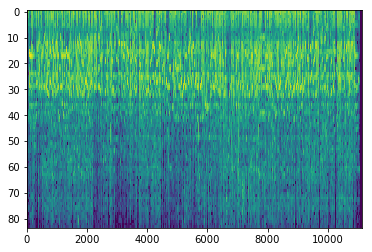

In [43]:
plt.imshow(F.T, interpolation="nearest", aspect="auto", cmap="viridis")

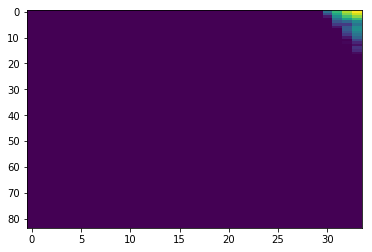

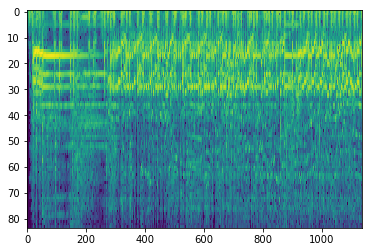

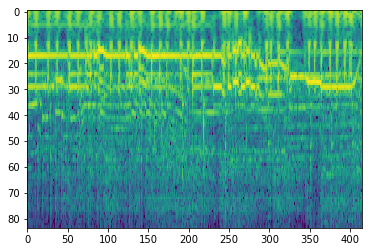

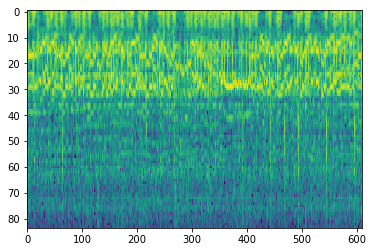

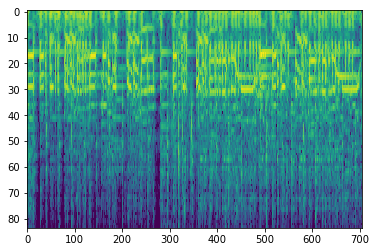

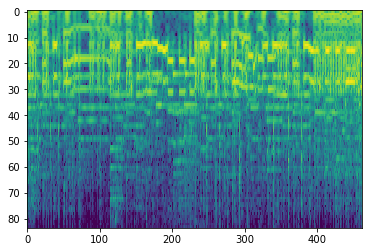

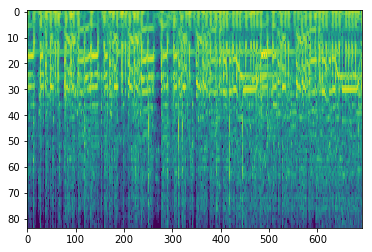

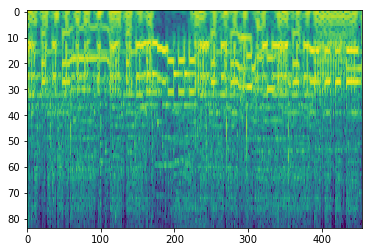

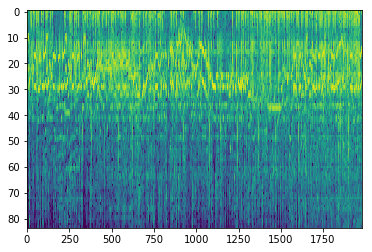

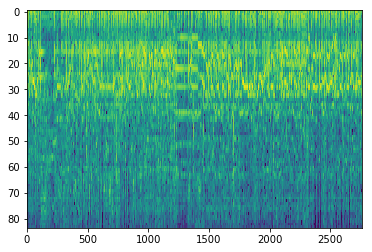

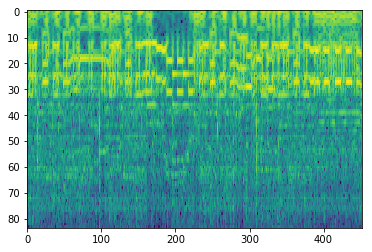

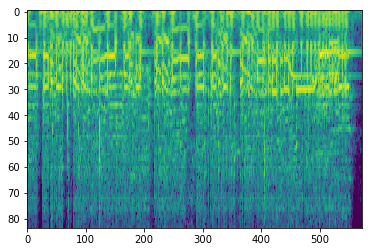

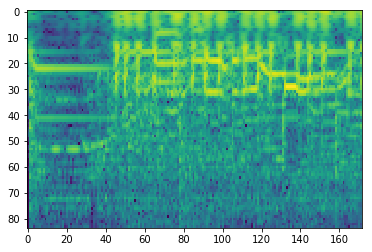

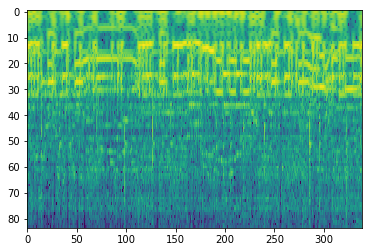

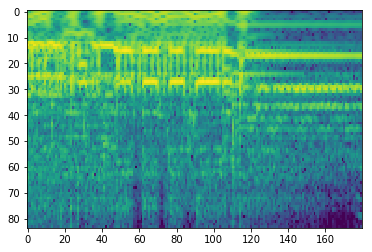

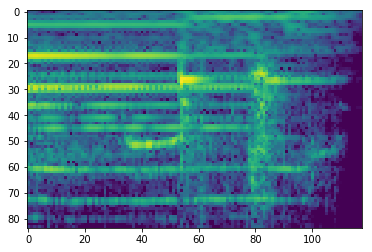

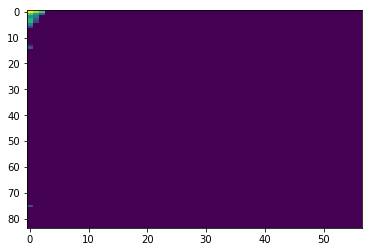

In [42]:
bounds = librosa.time_to_frames(references[0], sr=feats.sr, hop_length=feats.hop_length)
for interval in msaf.utils.times_to_intervals(bounds):
    plt.figure()
    plt.imshow(F[interval[0]:interval[1]].T, interpolation="nearest", aspect="auto", cmap="viridis")

# Average SALAMI Upper Segment Length

Let's compute the average segment length for all `function` and `upper` annotations in SALAMI. This will guide us to decide on the length of the training data.

Average: 22.97 seconds $\approx$ 495 frames

In [69]:
# Compute average segment length
jams_files = glob.glob("/home/uri/datasets/SALAMI/references/*.jams")
inter_times = []
for jams_file in jams_files:
    for ann in jams.load(jams_file).annotations:
        if ann.namespace == "segment_salami_function" or ann.namespace == "segment_salami_upper":
            inters, _ = ann.data.to_interval_values()
            inter_times += [inter[1] - inter[0] for inter in inters]
np.mean(inter_times)

22.97404575080899

In [72]:
# Get number of frames
np.mean(inter_times) * feats.sr / feats.hop_length

494.70479375521313

# Get Segment Patches

Actual training data

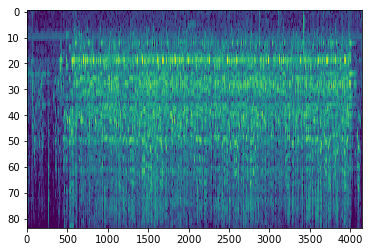

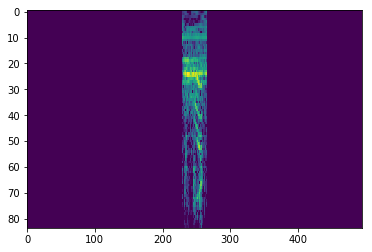

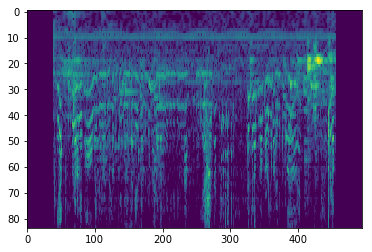

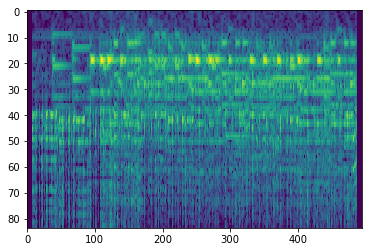

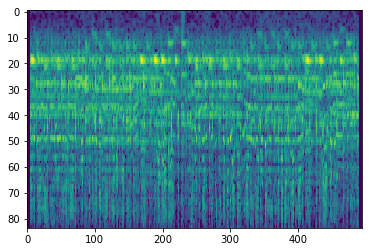

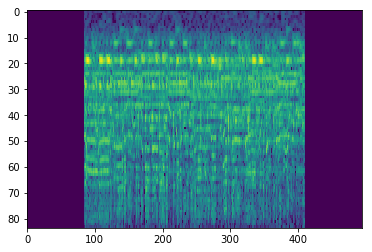

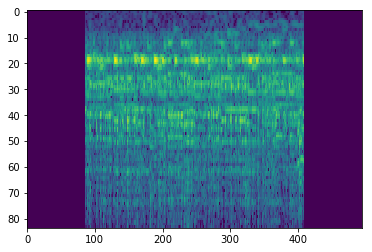

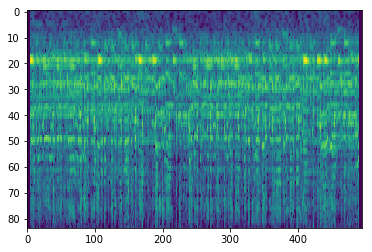

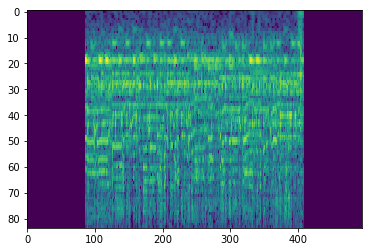

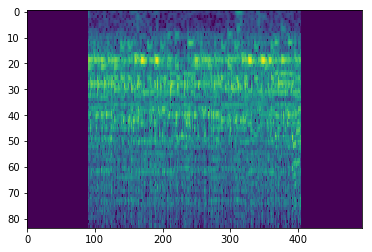

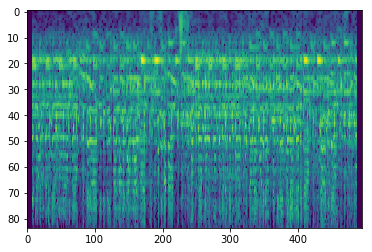

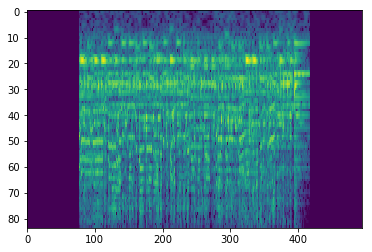

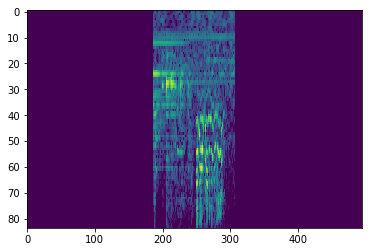

In [110]:
def get_patches(F, inters, n_frames=AVG_SIZE, n_bins=CQT_BINS, silence=SILENCE):
    patches = np.ones((len(inters), n_frames, n_bins)) * silence
    for i, inter in enumerate(inters):
        frame1 = librosa.time_to_frames(inter[0], sr=SR, hop_length=HOP_LEN)[0]
        frame2 = librosa.time_to_frames(inter[1], sr=SR, hop_length=HOP_LEN)[0]
        if frame2 > F.shape[0]:
            frame2 = F.shape[0]
        seg_len = frame2 - frame1
        if seg_len < n_frames:
            # Put in middle and zero pad
            start = int(n_frames / 2) - int(seg_len / 2)
            patches[i, start:start + seg_len] = F[frame1:frame2]
        else:
            # Crop segment
            start = int(seg_len / 2) - int(n_frames / 2)
            patches[i] = F[start:start + n_frames]
    return patches
        
mp3_files = glob.glob("/home/uri/datasets/SALAMI/audio/*.mp3")
for mp3_file in mp3_files:
    file_struct = msaf.input_output.FileStruct(mp3_file)
    feats = msaf.features.CQT(file_struct, msaf.base.FeatureTypes.framesync, n_bins=CQT_BINS,
                              hop_length=HOP_LEN, sr=SR)
    F = feats.features
    for ann in jams.load(file_struct.ref_file).annotations:
        if ann.namespace == "segment_salami_function" or ann.namespace == "segment_salami_upper":
            inters, labels = ann.data.to_interval_values()
            patches = get_patches(F, inters)
    break